# Import and pre-definitions

In [1]:
import os
MAIN_PATH = r'/home/luis-felipe'
DATA_PATH = os.path.join(MAIN_PATH,'data')
PATH_MODELS = os.path.join(MAIN_PATH,'torch_models')
FIGS_PATH = os.path.join(MAIN_PATH,'results','figs')

In [2]:
import torch
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Define o computador utilizado como cuda (gpu) se existir ou cpu caso contrário
print(torch.cuda.is_available())
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)
np.random.seed(42)

True


In [4]:
import sys
sys.path.insert(1, '..')
sys.path.insert(1, '../..')

import models
from utils import measures,metrics
from data_utils import upload_logits,split
import pNormSoftmax

# Evaluate logits

In [5]:
MODELS_ARC = ['efficientnetv2_xl','vit_b_32_sam','vit_l_16_384']
MODELS_ARC_NAMES = ['EfficientNet-V2-XL-21k-ft1k',
        'ViT-B/32-224-SAM',
        'ViT-L/16-384']
DATASET = 'ImageNet'

In [6]:
outputs_dict = {}
for i,n in enumerate(MODELS_ARC_NAMES):
    outputs_dict[n] = upload_logits(MODELS_ARC[i],DATASET,PATH_MODELS, 
                            split = 'test', device = dev)

In [9]:
(1,2,3,4)[2:]

(3, 4)

In [10]:
VAL_SIZE = 0.1 #5000
splitter = split(VAL_SIZE,50000)
outputs_val_dict = {n:splitter.logits(*outputs)[:2] for n,outputs in outputs_dict.items()}
outputs_test_dict = {n:splitter.logits(*outputs)[2:] for n,outputs in outputs_dict.items()}

#risk_val = measures.wrong_class(logits_val,labels_val).float()
#risk_test = measures.wrong_class(logits_test,labels_test).float()

In [18]:
AUROC_min = lambda x,y: 1-metrics.AUROC(x,y)
METRIC = AUROC_min

# Optimization and RC

In [20]:
RC_baseline_dict = {}
RC_opt_dict = {}
aurocs_dict = {}
for n,outputs in outputs_test_dict.items():
    p,beta = pNormSoftmax.optimize.p_and_beta(outputs_val_dict[n][0],measures.wrong_class(*outputs_val_dict[n]).float(),metric = METRIC)
    #p = pNormSoftmax.optimize.p(logits_val,risk_val,metric= metrics.AURC)
    #beta = pNormSoftmax.beta_heuristic(logits_val,p)
    RC_baseline_dict[n] = metrics.RC_curve(measures.wrong_class(*outputs).float(),measures.MSP(outputs[0]))
    RC_opt_dict[n] = metrics.RC_curve(measures.wrong_class(*outputs).float(),pNormSoftmax.pNormSoftmax(outputs[0],p,beta))
    aurocs_dict[n] = (metrics.AUROC(measures.wrong_class(*outputs).float(),measures.MSP(outputs[0])),
                      metrics.AUROC(measures.wrong_class(*outputs).float(),pNormSoftmax.pNormSoftmax(outputs[0],p,beta)))

# Plot

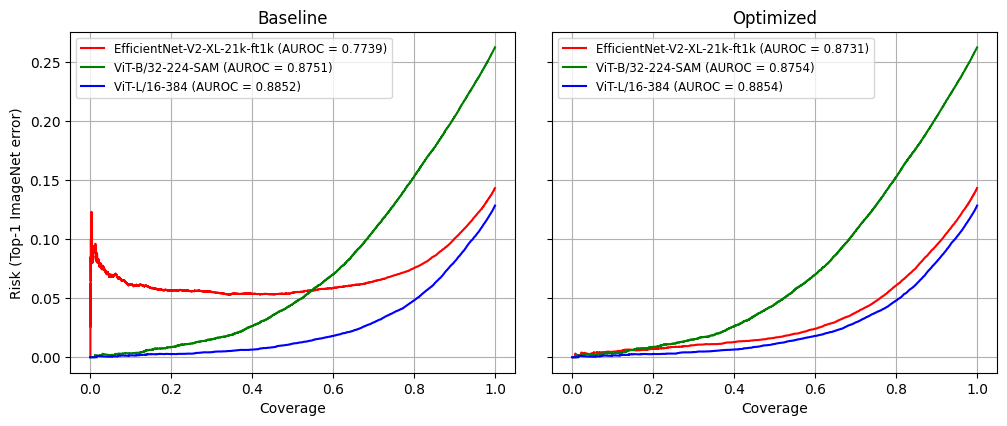

In [23]:
fig, axes = plt.subplots(1,2,figsize = (10,4), sharey=True)
fig.tight_layout()
axes[0].set_title('Baseline')
axes[1].set_title('Optimized')
axes[0].set_ylabel('Risk (Top-1 ImageNet error)')
colors = iter(['r','g','b'])
for model,outputs in RC_baseline_dict.items():
    color = next(colors)
    axes[0].plot(*outputs, label = model + f' (AUROC = {aurocs_dict[model][0]:.4f})', color = color)
    axes[1].plot(*RC_opt_dict[model], label = model + f' (AUROC = {aurocs_dict[model][1]:.4f})',color = color)

for ax in axes:
    ax.set_xlabel('Coverage')
    ax.legend(prop={'size': 8.5})
    ax.grid()
#tikzplotlib_fix_ncols(fig)
#tikzplotlib.save(os.path.join(PATH_RESULTS,'RC-Comparison.tex'))
plt.savefig(os.path.join(FIGS_PATH, f'RC-comparison.pdf'), transparent = True, format = 'pdf',bbox_inches = 'tight')
plt.show();